# Classification and Error Metrics

In [0]:
#imports
import pandas as pd
import numpy as np
          
def printRed(string): 
  print("\x1b[31m%s\x1b[0m"%(string))

def download_url(url, save_path):  
  import requests
  r = requests.get(url, stream=True)
  with open(save_path, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=128):
          fd.write(chunk)

In [0]:
# need to upload COVID19_line_list_data.csv manually
# downloading rest of the files from github

#url = 'https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv'
#download_url(url,'/content/COVID19_open_line_list.csv')
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
#download_url(url,'/content/time_series_covid19_confirmed_global.csv')
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv'
#download_url(url,'/content/csse_covid_19_daily_reports(03-31-2020).csv')
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
#download_url(url,'/content/time_series_covid19_deaths_global.csv')
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#download_url(url,'/content/time_series_covid19_recovered_global.csv')

## Introduction
After data analysis and visualization, identify the key features, convert them to suitable numeric format, and use only the processed features for further processing and prediction. Plot and observe the spread of the disease in other countries and identify top countries whose data can be used to predict the spread in Pakistan.

# Section 1

In this section will use [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) to classify if a patient will survive the COVID-19. You will use `COVID19_line_list_data.csv` and `COVID19_open_line_list.csv` for this assignment.

## Question 1
Explore both the CSVs mentioned above and argue which has more useful features for correctly classifying if a patient is likely to survive the COVID-19. Mention specific features from both files that will and will not correlate to the target (outcome).

In [65]:
def getnoncorr(cols,corr):
  notcorr = list()                
  for i in columns:
    if i not in corr:
      notcorr.append(i)
  return notcorr

printRed('COVID19_open_line_list.csv has more useful features for correctly \n\
classifying if a patient is likely to survive the COVID-19 as it \n\
contains the most important features (symptoms, date_admission_hospital).\n')

df = pd.read_csv('COVID19_line_list_data.csv')
columns = df.columns[:-6]
df = df[columns]

corr = ['location','country','gender','age','symptom_onset','hosp_visit_date',
        'exposure_start','exposure_end']

printRed('\nCOVID19_line_list_data.csv (correlating to the outcome)')
print(corr)
printRed('\nCOVID19_line_list_data.csv (not correlating to the outcome)')
print(getnoncorr(columns,corr))
print()

df_org = pd.read_csv('COVID19_open_line_list.csv')
columns = df_org.columns

corr = ['age','sex','city','province','country',                                # 'latitude', 'longitude',
                'date_onset_symptoms','date_admission_hospital','symptoms',
                'lives_in_Wuhan','chronic_disease','outcome']


printRed('\n\nCOVID19_open_line_list.csv (correlating to the outcome)')
print(corr)
printRed('\nCOVID19_open_line_list.csv (not correlating to the outcome)')
print(getnoncorr(columns,corr))

COVID19_open_line_list.csv has more useful features for correctly 
classifying if a patient is likely to survive the COVID-19 as it 
contains the most important features (symptoms, date_admission_hospital).


COVID19_line_list_data.csv (correlating to the outcome)
['location', 'country', 'gender', 'age', 'symptom_onset', 'hosp_visit_date', 'exposure_start', 'exposure_end']

COVID19_line_list_data.csv (not correlating to the outcome)
['id', 'case_in_country', 'reporting date', 'Unnamed: 3', 'summary', 'If_onset_approximated', 'visiting Wuhan', 'from Wuhan', 'death', 'recovered', 'symptom', 'source', 'link']



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)




COVID19_open_line_list.csv (correlating to the outcome)
['age', 'sex', 'city', 'province', 'country', 'date_onset_symptoms', 'date_admission_hospital', 'symptoms', 'lives_in_Wuhan', 'chronic_disease', 'outcome']

COVID19_open_line_list.csv (not correlating to the outcome)
['ID', 'latitude', 'longitude', 'geo_resolution', 'date_confirmation', 'travel_history_dates', 'travel_history_location', 'reported_market_exposure', 'additional_information', 'chronic_disease_binary', 'source', 'sequence_available', 'date_death_or_discharge', 'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1', 'country_new', 'admin_id', 'data_moderator_initials', 'travel_history_binary']


## Question 2

Import the chosen file and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Remove extra feature columns
* Encode the non-numeric values as an integer
* Determine the breakdown of target values

In [0]:
#encoding age

def encodeage(col):
  encoded = list()
  summ = list()
  for i in col:
    if i!='~':
      if '-' in str(i):
        ind = i.index('-')
        age = i[ind+1:]
        if len(age)==0:
          age = i[:ind]
        age = round(float(age))
        summ.append(age)
        encoded.append(age)
      else:
        age = round(float(i))
        summ.append(age)
        encoded.append(age)
    else:
      encoded.append('~')

  encoded = np.array(encoded)
  avg = round(sum(summ)/len(summ))
  return avg, np.where(encoded=='~',avg,encoded).astype(int)  # replacing no data with avg

In [0]:
#encoding sex

def encodesex(col):
  encoded = list()
  for i in col:
    if i=='female':
      encoded.append(1)
    elif i=='male':
      encoded.append(2)
    else:
      encoded.append(0)
  return encoded

In [0]:
#encoding city, province, country

def encodecpc(cpc):
  uniqdict = dict()
  encoded = list()
  columns = ['city','province','country']
  for i in columns:
    enc = list()
    uniq = ['~']
    col = cpc[i].values
    for j in col:
      if j not in uniq:
        uniq.append(j)
      enc.append(uniq.index(j))
      
    encoded.append(enc)
    uniqdict.update({i:uniq})

  return uniqdict,encoded

In [0]:
#encoding symptoms

def formatsymp(row, st, splitt=True):
  if splitt:
    row = row.split(st)
  for i in range(len(row)):
    row[i] = row[i].strip().lower()    
    if 'fever' in row[i]:
      row[i] = 'fever'
  return row

def extractsymptoms(row):
  row = str(row)
  if ',' in row:
    return formatsymp(row, ',')
  elif ';' in row:
    return formatsymp(row, ';')
  elif 'and' in row:
    return formatsymp(row, 'and')
  else:
    return formatsymp([row], '', False)

def addsymp(symp, uniq):
  add = 0
  for i in symp:
    add+= uniq.index(i)
  return add

def encodesymp(col):
  uniq = list()
  encoded = list()
  for i in col:
    symptoms = extractsymptoms(i) #extracting individial symptoms
    for s in symptoms:
      if s not in uniq:
        uniq.append(s)
    encoded.append(addsymp(symptoms, uniq)**2+1) #encoding by adding symptoms values
  return uniq, encoded

In [0]:
#encoding dates (date_admission_hospital - date_onset_symptoms)
from datetime import date 

def difdays(a,b):
  try:
    date1 = date(int(a[2][:4]),int(a[1]),int(a[0]))
  except:
    date1 = date(int(a[2]),int(a[0]),int(a[1]))
  try:
    date2 = date(int(b[2]),int(b[1]),int(b[0]))
  except:
    date2 = date(int(b[2]),int(b[0]),int(b[1]))
  diff = (date2-date1).days
  if diff<0:
    diff=0
  return diff

def encodedates(d1,d2): 
  encoded = list()
  summ = list()
  for i in range(len(d1)):
    if '.' in d1[i] and '.' in d2[i]:
      a = d1[i].split('.')
      b = d2[i].split('.')
      if len(a)==3 and len(b)==3:
        diff = difdays(a,b)
        encoded.append(diff)
        summ.append(diff)
      else:
        a[2] = a[2][:4]
        b[2] = b[2][:4]
        diff = difdays(a[:3],b[:3])
        encoded.append(diff)
        summ.append(diff)
    else:
      encoded.append('~')
  encoded = np.array(encoded)
  avg = round(sum(summ)/len(summ))
  return avg, np.where(encoded=='~',avg,encoded).astype(int) # replacing no data with avg

In [0]:
#encoding lives_in_Wuhan

def encodewuhan(col):
  encoded = list()
  for i in col:
    if i=='yes' or 'Wuhan' in i:
      encoded.append(2)
    elif i=='~':
      encoded.append(0)
    else:
      encoded.append(1)
  return encoded

In [0]:
#encoding outcome

def formatoutcome(i):
  dead = ['dead','death','deceased','died']
  stable = ['alive','symptoms only improved with cough. currently hospitalized for follow-up.']
  unstable = ['severe','severe illness','unstable']
  if i in dead:
    i = 'dead'
  elif 'critical condition' in i:
    i = 'dead'
  elif i in unstable:
    i = 'dead'
    
  elif 'discharge' in i:
    i = 'recovered'
  elif 'recover' in i:
    i = 'recovered'
  elif 'released' in i:
    i = 'recovered'
  elif 'not hospitalized' in i:
    i = 'recovered'
  elif 'stable' in i:
    i = 'recovered'
  elif 'treat' in i:
    i = 'recovered'
  elif i in stable:
    i = 'recovered'
  else:
    i = 'recovered'

  return i

def encodeoutcome(col):
  col = [x.lower() for x in col]
  uniq = ['recovered','dead']
  encoded = list()
  for i in col:
    i = formatoutcome(i)
    encoded.append(uniq.index(i))

  return uniq,encoded

In [0]:
#encoding latlong (distance from USA)

def encodelatlong(latlong):
  from math import sqrt,pow

  USA = (39.381266,-97.922211)
  lat = latlong['latitude'].values
  lon = latlong['longitude'].values
  encoded = list()
  summ = list()
  for i in range(latlong.shape[0]):
    x, y = lat[i],lon[i]
    if x=='~' or y=='~':
      encoded.append('~')
    else:
      dist = sqrt(pow(float(x) - USA[0], 2) + pow(float(y) - USA[1], 2)) #distance between two points formula
      encoded.append(dist)
      summ.append(dist)
  
  encoded = np.array(encoded)
  avg = sum(summ)/len(summ)
  return np.where(encoded=='~',avg,encoded).astype(float) # replacing no data with avg

In [0]:
def getelements(splts):
  elems = list()
  for i in splts:
    length = len(i)
    for j in range(length):
      elems.append(i[j])
  return elems

def formatchronic(chrnc):
  import re

  r = getelements([re.split(',+',w) for w in chrnc])
  r = getelements([re.split(':+',w) for w in r])
  r = getelements([re.split(' +',w) for w in r])
  return np.array(r)

def encodechronic(chrnc):
  encoded = list()
  uniq = ['~']
  for i in chrnc:
    r = formatchronic([i])
    summ = 0
    for j in r:
      if j not in uniq:
        uniq.append(j)
      summ+=uniq.index(j)
    encoded.append(summ*2)

  return encoded

In [75]:
df = df_org.copy()
df = df[corr]
df = df.replace(np.nan,'~')
df = df[df['outcome'] != '~']

age = df['age'].values
sex = df['sex'].values
cpc = df[['city','province','country']]
#latlong = df[['latitude','longitude']]
allsymp = df['symptoms'].values
onsetsymp = df['date_onset_symptoms'].values
admissymp = df['date_admission_hospital'].values
liveswuhan = df['lives_in_Wuhan'].values
chrnc = df['chronic_disease'].values
outcome = df['outcome'].values

avgage, encage = encodeage(age)                       # special encoding for age
encsex = encodesex(sex)                               # special encoding for sex
uniqcpc, enccpc = encodecpc(cpc)                      # special encoding for city, province, country (cpc)
#enclatlong = encodelatlong(latlong)                  # special encoding for lat,long by calculating distance from USA (highest death rate)
uniqsymp, encsymp = encodesymp(allsymp)               # special encoding for symptoms + feature scaling
avgdate, encdates = encodedates(onsetsymp, admissymp) # special encoding for dates (date_admission_hospital - date_onset_symptoms)
encwuhan = encodewuhan(liveswuhan)                    # special encoding for lives_in_Wuhan
enccd = encodechronic(chrnc)                          # special encoding for chronic_disease
uniqoutcome, encoutcome = encodeoutcome(outcome)      # binary encoding for outcome

encdf = df.copy()
encdf['age'] = encage
encdf['sex'] = encsex
encdf['city'] = enccpc[0]
encdf['province'] = enccpc[1]
encdf['country'] = enccpc[2]
#encdf['latitude'] = enclatlong
#encdf = encdf.drop(['longitude'],axis=1)
encdf['symptoms'] = encsymp
encdf['date_admission_hospital'] = encdates
encdf = encdf.drop(['date_onset_symptoms'],axis=1)
encdf['lives_in_Wuhan'] = encwuhan
encdf['chronic_disease'] = enccd
encdf['outcome'] = encoutcome

encdf

,age,sex,city,province,country,date_admission_hospital,symptoms,lives_in_Wuhan,chronic_disease,outcome
0,55,2,1,1,1,4,1,0,0,1
1,78,2,2,2,2,4,1,0,0,1
2,61,1,0,0,3,4,1,0,0,0
113,28,2,0,0,3,4,1,0,0,0
224,56,1,0,0,3,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
205042,89,1,74,30,16,4,1,0,0,1
205043,49,1,43,30,16,4,1,0,0,0
214180,80,1,172,105,16,4,1,0,0,1
216605,99,1,74,30,16,4,1,0,0,1


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

totalclasses = np.bincount(encoutcome)
printRed(f'Total {uniqoutcome[0]}: {totalclasses[0]},\tTotal {uniqoutcome[1]}: {totalclasses[1]}')

X = encdf[[col for col in encdf.columns if col != 'outcome']].values
y = encdf['outcome'].values
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

count=1
for train_index, test_index in sss.split(X, y):
  y_train = y[train_index]
  y_test = y[test_index]
  traincr = np.bincount(y_train) / totalclasses
  testcr = np.bincount(y_test) / totalclasses
  print(f'Split Ratio TRAIN #{count} {traincr}',f'\tSplit Ratio TEST #{count} {testcr}')
  count+=1

Total recovered: 1021,	Total dead: 224
Split Ratio TRAIN #1 [0.6993144  0.70089286] 	Split Ratio TEST #1 [0.3006856  0.29910714]


## Question 4

Let's now fit a Naive Bayes classifier to this data in order to predict "outcome".

* Pick the appropriate type of Naive Bayes given the nature of your dataset (data types of columns).Choices are:
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [78]:
printRed('Since most of the features have discrete values, I will choose MultinomialNB\n')

cv = 5
mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X, y, cv=cv, n_jobs=-1)
mavg = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score:\t{mcvs}\n')
printRed(f'My choice works very well giving an average cross val score of {mavg} %')

Since most of the features have discrete values, I will choose MultinomialNB

MultinomialNB Cross Val Score:	[0.81124498 0.87951807 0.58634538 0.97991968 0.81927711]

My choice works very well giving an average cross val score of 81.5 %


## Question 5

Now let's try all types of Naive Bayes and observe what happens

* Compare the cross validation scores for Gaussian, Bernouilli and Multinomial Naive Bayes.
* Why is BernoulliNB performing like it does?

In [79]:
gnb = GaussianNB()
gcvs = cross_val_score(gnb, X, y, cv=cv, n_jobs=-1)
gavg = str(np.mean(gcvs)*100)[:4]
print(f'GaussianNB Cross Val Score:\t{gcvs},\tAverage acc: {gavg} %\n')

mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X, y, cv=cv, n_jobs=-1)
mavg = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score:\t{mcvs},\tAverage acc: {mavg} %\n')

bnb = BernoulliNB()
bcvs = cross_val_score(bnb, X, y, cv=cv, n_jobs=-1)
bavg = str(np.mean(bcvs)*100)[:4]
print(f'BernoulliNB Cross Val Score:\t{bcvs},\tAverage acc: {bavg} %\n')
printRed(f'BernoulliNB has {bavg} % score because it only works well on binary features (0,1)')

GaussianNB Cross Val Score:	[0.7751004  0.88353414 0.92369478 0.97188755 0.73092369],	Average acc: 85.7 %

MultinomialNB Cross Val Score:	[0.81124498 0.87951807 0.58634538 0.97991968 0.81927711],	Average acc: 81.5 %

BernoulliNB Cross Val Score:	[0.67871486 0.89156627 0.91164659 0.96385542 0.47389558],	Average acc: 78.3 %

BernoulliNB has 78.3 % score because it only works well on binary features (0,1)


## Question 6

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix (plot)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

	GaussianNB
Accuracy:	0.8903743315508021
Precision:	0.782608695652174
Recall:		0.5373134328358209
fscore:		0.6371681415929203


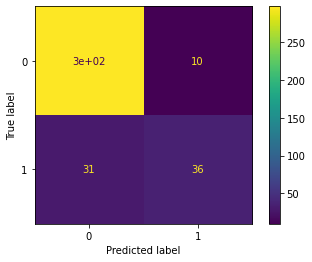

In [81]:
def getdetails(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  prc = precision_score(y_true, y_pred, average='binary')
  rcl = recall_score(y_true, y_pred, average='binary')
  fsc = f1_score(y_true, y_pred, average='binary')
  print(f'Accuracy:\t{acc}\nPrecision:\t{prc}\nRecall:\t\t{rcl}\nfscore:\t\t{fsc}')

def getall(clf, X, y, splits):
  for train_index, test_index in splits:
    clf.fit(X[train_index], y[train_index])    
    y_pred = clf.predict(X[test_index])
    getdetails(y[test_index], y_pred)
    plot_confusion_matrix(clf, X[test_index], y[test_index])

printRed('\tGaussianNB')
getall(GaussianNB(), X, y, sss.split(X,y))

	MultinomialNB
Accuracy:	0.8235294117647058
Precision:	0.5079365079365079
Recall:		0.47761194029850745
fscore:		0.4923076923076923


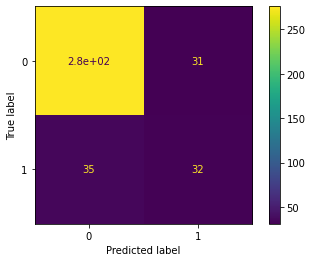

In [82]:
printRed('\tMultinomialNB')
getall(MultinomialNB(), X, y, sss.split(X,y))

	BernoulliNB
Accuracy:	0.8529411764705882
Precision:	0.5909090909090909
Recall:		0.582089552238806
fscore:		0.5864661654135339


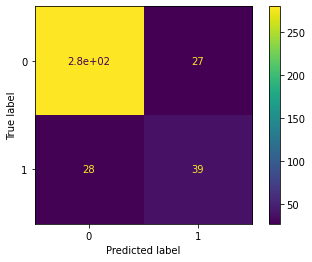

In [83]:
printRed('\tBernoulliNB')
getall(BernoulliNB(), X, y, sss.split(X,y))

## Question 7
Let's dive more into the feature analysis.
* Create a bar plot showing the correlations between each column and `outcome`
* Pick the most 5 correlated fields (using the absolute value of correlations) and create new `X`
* Re-train your chosen Naive Bayes classifier to this data, and compare results

age                        0.437707
sex                        0.364319
city                       0.431488
province                   0.375641
country                    0.171222
date_admission_hospital    0.087903
symptoms                   0.348000
lives_in_Wuhan             0.139391
chronic_disease            0.382566
outcome                    1.000000
Name: outcome, dtype: float64


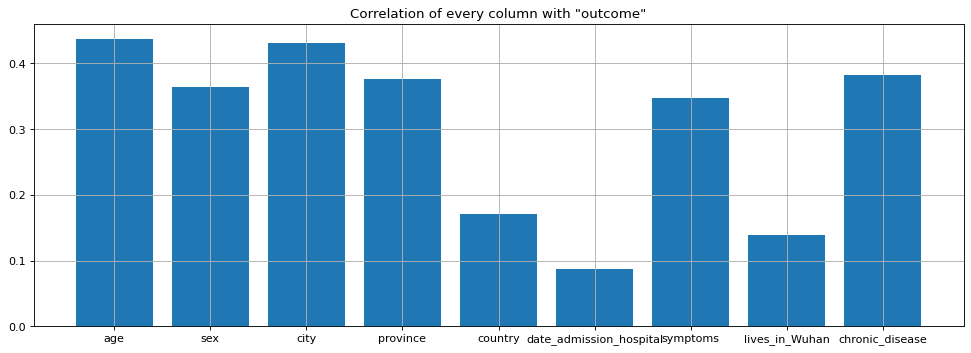

In [84]:
corr_matrix = encdf.corr()['outcome'].abs()
print(corr_matrix)

xaxis = corr_matrix[:-1].keys()
yaxis = corr_matrix[:-1]

plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(xaxis,yaxis)
plt.grid(True)
plt.title('Correlation of every column with "outcome"')
plt.show()

corr_matrix = corr_matrix.sort_values(ascending=False)
xaxis = corr_matrix[1:].keys()
topcols = list(xaxis[:5])
topcols.append('outcome')

newdf = encdf.copy()
newdf = newdf[topcols]

Retraining chosen MultinomialNB

MultinomialNB Cross Val Score:	[0.81927711 0.87148594 0.86345382 0.92771084 0.83935743]

Average cross val score has increased from 81.5 % to 86.4 %

Accuracy:	0.8796791443850267
Precision:	0.7619047619047619
Recall:		0.47761194029850745
fscore:		0.5871559633027523


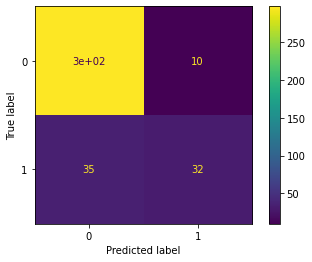

In [85]:
printRed('Retraining chosen MultinomialNB\n')

X_new = newdf[[col for col in newdf.columns if col != 'outcome']].values
y_new = newdf['outcome'].values

mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X_new, y_new, cv=cv, n_jobs=-1)
mavg_new = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score:\t{mcvs}\n')
if mavg<mavg_new:
  res = 'increased'
else:
  res = 'decreased'
printRed(f'Average cross val score has {res} from {mavg} % to {mavg_new} %\n')

getall(GaussianNB(), X_new, y_new, sss.split(X_new,y_new))

<hr>

# Section 2

In this section will use [Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19) to observe the spreading trend of COVID-19. You are required to use the data reported till **31-March-2020**.

## Question 1
Use `time_series_covid19_confirmed_global.csv` and plot the trend of disease spread in 10 most affected countries.

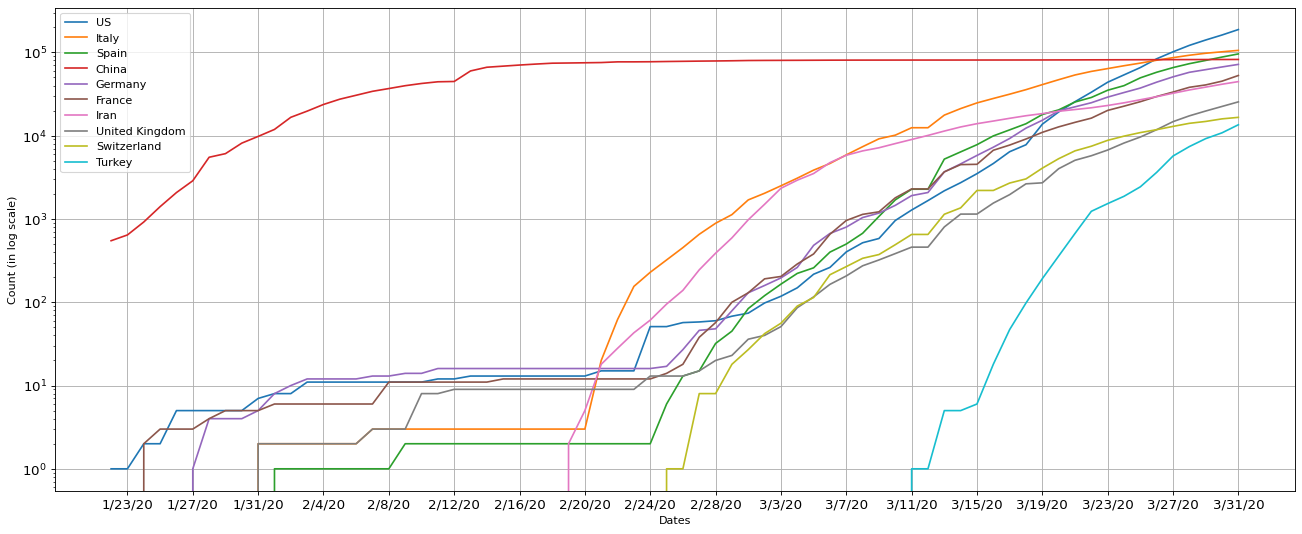

In [86]:
def countrywise(df, allCountries, uniqcountries):
  lists = list()
  for i in uniqcountries:
    index = np.where(allCountries == i)
    rows = df.iloc[index].values[:,4:]
    confirmsum = rows.sum(axis=0)
    lists.append([i,confirmsum])
  return lists

stwodf = pd.read_csv('time_series_covid19_confirmed_global.csv')
stwodf = stwodf.iloc[:,:14+29+31] #get first columns till 31st March
cols = stwodf.columns[4:]

allcountries = stwodf['Country/Region'].values
uniqcountries = np.unique(allcountries)

cnt = countrywise(stwodf, allcountries, uniqcountries)
cntdesc = np.array(sorted(cnt,key=lambda l:l[1][-1], reverse=True)) #descending order wrt 2nd column
topten = cntdesc[:10]

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
  plt.plot(cols, topten[:,1][i], label = topten[:,0][i])
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(np.arange(1, len(cols),4))
plt.xlabel('Dates')
plt.ylabel('Count (in log scale)')
plt.grid(True)
plt.legend()
plt.show()

## Question 2
Use `csse_covid_19_daily_reports` to compare the mortality and survival rates in 10 most affected countries as of 31-March-2020.

In [87]:
def gettopcountries(uniqcnt, drdf):  
  allcnt = list()
  for i in uniqcnt:
    rows = drdf.loc[drdf['Country_Region'] == i]
    confirmed = rows['Confirmed'].sum()
    deaths = rows['Deaths'].sum()
    recovered = rows['Recovered'].sum()
    allcnt.append([i,confirmed,deaths,recovered])
  return allcnt

def formats(a,b):
  return str(a/b*100)[:4]

def getrates(countries):
  for i in countries:
    printRed(i[0])
    print(f'Mortality Rate: {formats(i[2],i[1])} % \tSurvival Rate: {formats(i[2],i[1])} %')

drdf = pd.read_csv('csse_covid_19_daily_reports(03-31-2020).csv')
uniqcnt = np.unique(drdf['Country_Region'].values)

allcnt = gettopcountries(uniqcnt, drdf)
topcnt = sorted(allcnt,key=lambda x: x[1], reverse=True)[:10]
getrates(topcnt)

US
Mortality Rate: 2.05 % 	Survival Rate: 2.05 %
Italy
Mortality Rate: 11.7 % 	Survival Rate: 11.7 %
Spain
Mortality Rate: 8.82 % 	Survival Rate: 8.82 %
China
Mortality Rate: 4.02 % 	Survival Rate: 4.02 %
Germany
Mortality Rate: 1.07 % 	Survival Rate: 1.07 %
France
Mortality Rate: 6.68 % 	Survival Rate: 6.68 %
Iran
Mortality Rate: 6.49 % 	Survival Rate: 6.49 %
United Kingdom
Mortality Rate: 7.03 % 	Survival Rate: 7.03 %
Switzerland
Mortality Rate: 2.60 % 	Survival Rate: 2.60 %
Turkey
Mortality Rate: 1.58 % 	Survival Rate: 1.58 %


## Question 3
Identify top 5 countries (min 1000 cases) which have same spread trend as **Pakistan**. Compare progression of virus in 7 days moving window of these countries in terms of confirmed cases, deaths, and recoveries.

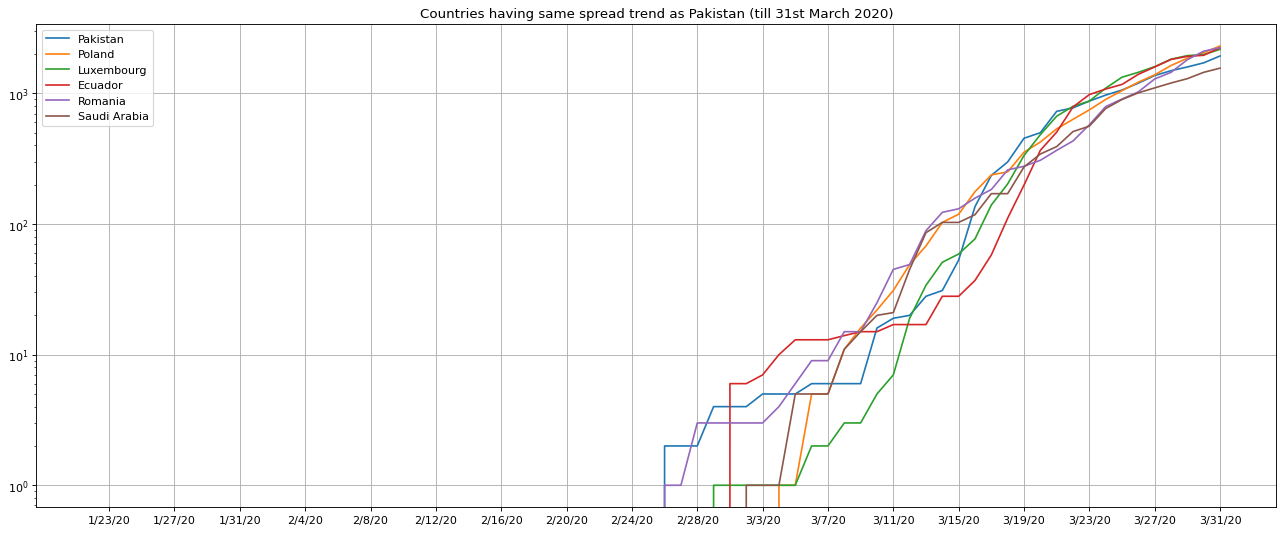

In [88]:
def getminthousands(countries):
  minthousand = list()
  for i in countries:
    if i[1][-1]>999:
      if i[0]=='Pakistan':
        pak = [i[0],i[1]]
      minthousand.append([i[0],i[1]])
  return pak, minthousand

def finddeviation(pak, restcountries):
  dev = list()
  for i in restcountries:
    subsum = sum(np.abs(i[1]-pak[1]))
    dev.append([i[0],subsum])    
  return np.array(sorted(dev,key=lambda l:l[1]))

def plottrend(cols, minthousand, allCountries, topfive):
  minthousand = np.array(minthousand)
  plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
  for i in topfive:
    index = np.where(minthousand[:,0] == i)
    rows = minthousand[index][0][1]
    plt.plot(cols,rows,label=i)
  plt.yscale('log')
  plt.xticks(np.arange(1, len(cols),4))
  plt.grid(True)
  plt.legend()
  plt.title('Countries having same spread trend as Pakistan (till 31st March 2020)')
  plt.show()

pak, minthousand = getminthousands(cntdesc) # getting Pakistan and rest countries with atleast 1000 cases
dev = finddeviation(pak, minthousand)       # countries with least deviation from Pakistan (in ascending order)
topfive = dev[:6][:,0]                      # top 5 countries with save treand as Pakistan (5+1)
plottrend(cols, minthousand, allcountries, topfive)

In [0]:
def nmovingwindow(countries,n,columns):
  for i in countries:
    cols = list()
    nwindow = list()
    for j in range(len(i[1])):
      if j%n==0:
        nwindow.append(i[1][j])
        cols.append(columns[j])
    i[1] = nwindow
  return np.array(countries), cols

def plotprogress(countries, cols, case):
  plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
  for i in range(len(countries)):
    plt.plot(cols,countries[:,1][i], label=countries[:,0][i])
  #plt.yscale('log')
  plt.grid(True)
  plt.legend()
  plt.title(f'({case} Cases) Progression of COVID-19 in 7 days moving window (till 31st March 2020)')
  plt.show()

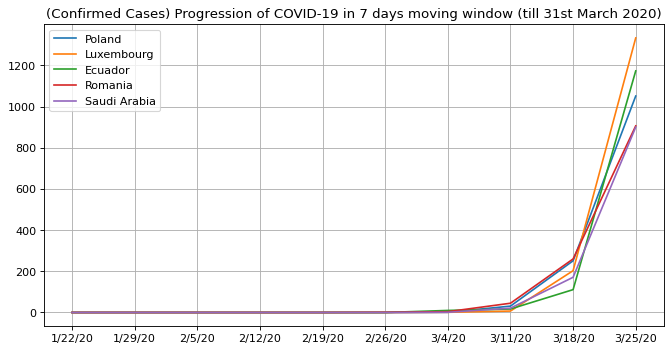

In [90]:
stwodf = pd.read_csv('time_series_covid19_confirmed_global.csv')
stwodf = stwodf.iloc[:,:14+29+31] #get first n columns till 31st March
cols = stwodf.columns[4:]
allcountries = stwodf['Country/Region'].values

cnt = countrywise(stwodf, allcountries, topfive[1:])
countries, cols = nmovingwindow(cnt, 7, cols)
plotprogress(countries, cols, 'Confirmed')

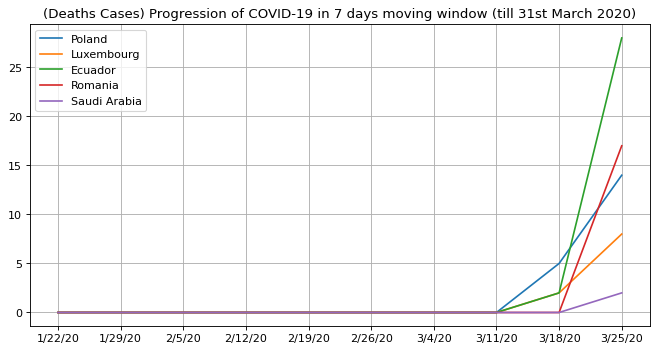

In [91]:
stwodf = pd.read_csv('time_series_covid19_deaths_global.csv')
stwodf = stwodf.iloc[:,:14+29+31] #get first n columns till 31st March
cols = stwodf.columns[4:]
allcountries = stwodf['Country/Region'].values

cnt = countrywise(stwodf, allcountries, topfive[1:])
countries, cols = nmovingwindow(cnt, 7, cols)
plotprogress(countries, cols, 'Deaths')

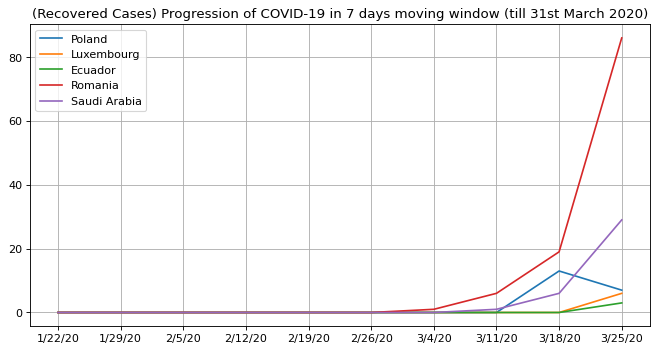

In [92]:
stwodf = pd.read_csv('time_series_covid19_recovered_global.csv')
stwodf = stwodf.iloc[:,:14+29+31] #get first n columns till 31st March
cols = stwodf.columns[4:]
allcountries = stwodf['Country/Region'].values

cnt = countrywise(stwodf, allcountries, topfive[1:])
countries, cols = nmovingwindow(cnt, 7, cols)
plotprogress(countries, cols, 'Recovered')

<hr>

## Bonus
Calculate and plot the min, max, average, median number of days for a patient to recover using one of the data files mentioned above. <br>**Hint:** use `boxplot`

Days to Recover
Min: 1.0
Max: 33.0
Average: 14.828402366863905
Median: 14.0



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


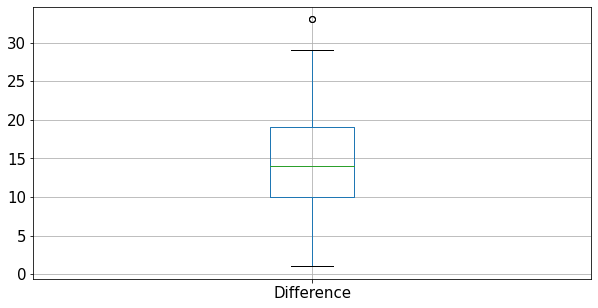

In [93]:
def getindex(out):
  indx = list()
  for i in out:
    if (formatoutcome(i)=='recovered'):
      indx.append(True)
    else:
      indx.append(False)
  return indx

def daystorecover(dataframe):
  d1 = dataframe['date_admission_hospital'].values
  d2 = dataframe['date_death_or_discharge'].values
  _, diff = encodedates(d1,d2)                                                  # using encodedates formula which was used for encoding df
  return diff

admitreleased = df_org[['date_admission_hospital','outcome','date_death_or_discharge']]
admitreleased = admitreleased.replace(np.nan,'~')
admitreleased = admitreleased[admitreleased['date_admission_hospital'] != '~']  # removing rows where date_admission_hospital in blank
admitreleased = admitreleased[admitreleased['date_death_or_discharge'] != '~']  # removing rows where date_death_or_discharge in blank
admitreleased = admitreleased[getindex(admitreleased['outcome'].values)]        # using formatoutcome's formatting criteria

diff = daystorecover(admitreleased)

box = pd.DataFrame(diff, columns=['Difference'])
box.boxplot(grid='True', figsize=(10, 5), fontsize=15)
data = box.describe().values                                                    # using boxplot to find needed values

minn = data[3][0]
maxx = data[7][0]
avg = data[1][0]
median = data[5][0]

printRed('Days to Recover')
print(f'Min: {minn}\nMax: {maxx}\nAverage: {avg}\nMedian: {median}\n')